In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
!nvidia-smi
!rm -rf aclImdb

Mon Apr 19 14:31:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    71W / 149W |  11338MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Instal apex if you want to do 16 bit training. You'll probably need to restart the notebook after installing apex

In [85]:
# !export CUDA_HOME=/usr/local/cuda-10.1
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [ ]:
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5
!pip install sentencepiece

     |████████████████████████████████| 645kB 10.7MB/s 
     |████████████████████████████████| 5.6MB 27.0MB/s 
     |████████████████████████████████| 1.2MB 39.0MB/s 
     |████████████████████████████████| 901kB 38.9MB/s 
     |████████████████████████████████| 235kB 10.8MB/s 
     |████████████████████████████████| 829kB 22.4MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=83770ca48afa5c9bde5fe3c310c9019274409a0aa7dcc165d74632aa5de8a340
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


## T5 fine-tuning

This notebook is to showcase how to fine-tune [T5 model](https://arxiv.org/abs/1910.10683) with Huggigface's [Transformers](https://github.com/huggingface/transformers/) to solve different NLP tasks using text-2-text approach proposed in the T5 paper. For demo I chose 3 non text-2-text problems just to reiterate the fact from the paper that how widely applicable this text-2-text framework is and how it can be used for different tasks without changing the model at all.

This is a rough draft so if you find any issues with this notebook or have any  questions reach out to me via [Twitter](https://twitter.com/psuraj28).



In [86]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [87]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(21)

## Model

We'll be using the awesome [pytorch-lightning](https://github.com/PytorchLightning/pytorch-lightning) library for training. Most of the below code is adapted from here https://github.com/huggingface/transformers/blob/master/examples/lightning_base.py

The trainer is generic and can be used for any text-2-text task. You'll just need to change the dataset. Rest of the code will stay unchanged for all the tasks.

This is the most intresting and powrfull thing about the text-2-text format. You can fine-tune the model on variety of NLP tasks by just formulating the problem in text-2-text setting. No need to change hyperparameters, learning rate, optimizer or loss function. Just plug in your dataset and you are ready to go!

In [88]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [89]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

Let's define the hyperparameters and other arguments. You can overide this `dict` for specific task as needed. While in most of cases you'll only need to change the `data_dir`and `output_dir`.

Here the batch size is 8 and gradient_accumulation_steps are 16 so the effective batch size is 128

In [90]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-small',
    tokenizer_name_or_path='t5-small',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=21,
)

## IMDB review classification

### Download IMDB Data

In [91]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xvf aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [92]:
train_pos_files = glob.glob('aclImdb/train/pos/*.txt')
train_neg_files = glob.glob('aclImdb/train/neg/*.txt')

In [93]:
len(train_pos_files), len(train_neg_files)

(12500, 12500)

We will use 2000 samples from the train set for validation. Let's choose 1000 postive reviews and 1000 negative reviews for validation and save them in the val directory

In [94]:
!mkdir aclImdb/val aclImdb/val/pos aclImdb/val/neg

In [95]:
random.shuffle(train_pos_files)
random.shuffle(train_neg_files)

val_pos_files = train_pos_files[:1000]
val_neg_files = train_neg_files[:1000]

In [96]:
import shutil

In [97]:
for f in val_pos_files:
  shutil.move(f,  'aclImdb/val/pos')
for f in val_neg_files:
  shutil.move(f,  'aclImdb/val/neg')

### Prepare Dataset

In [98]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [99]:
ids_neg = tokenizer.encode('negative </s>')
ids_pos = tokenizer.encode('positive </s>')
len(ids_neg), len(ids_pos)

(2, 2)

All the examples are converted in the text-2-text format as shown in the paper. However I didn't use any task prefix here. The examples are encoded as follows,
if the review is positive then the target is 'positive' else 'negative'

**input**:  I went to see this
movie with my husband, and we both
thought the acting was terrible!"

**target**: negative

**input**:  Despite what others say,
I thought this movie was funny.

**target**: positive

The dataset below takes care of reading the review files and processing the examples in text-2-text format.

It cleans the review text by removing the html tags. It also appends the eos token `</s>` at the end of input and target as required by the T5 model 

For T5 max input length is 512 and we can choose the max length for target sequence depending upon our dataset. The `T5Tokenizer` encodes both 'postive' and 'negative' as a single ids so I chose the max target length 2, extra 1 for the `</s>` token

In [100]:
class ImdbDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.pos_file_path = os.path.join(data_dir, type_path, 'pos')
    self.neg_file_path = os.path.join(data_dir, type_path, 'neg')
    
    self.pos_files = glob.glob("%s/*.txt" % self.pos_file_path)
    self.neg_files = glob.glob("%s/*.txt" % self.neg_file_path)
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    self._buil_examples_from_files(self.pos_files, 'positive')
    self._buil_examples_from_files(self.neg_files, 'negative')
  
  def _buil_examples_from_files(self, files, sentiment):
    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

    for path in files:
      with open(path, 'r') as f:
        text = f.read()
      
      line = text.strip()
      line = REPLACE_NO_SPACE.sub("", line) 
      line = REPLACE_WITH_SPACE.sub("", line)
      line = line + ' </s>'

      target = sentiment + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [line], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [101]:
dataset = ImdbDataset(tokenizer, 'aclImdb', 'val',  max_len=512)
len(dataset)

2000

In [102]:
data = dataset[28]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

Lets start this review out on a positive note I am very glad they didnt decide to wimp out with Tony being shot and do a retrospective season like some people were rumoring Actually creator and writer of this episode David Chase did quite the opposite We dont actually know if Tony will live or die Hes in a coma and his chances of recovering are very slim to none This episode seemed to move very slow and the coma induced dream Tony was in involving mistaken identity and robed Asian monks slapping the sh*t out of him was absolutely flatout weird After 45minutes I got a little sick of everyone grieving but that shouldn t be a reason to slam this episode It was a weird and unpredictable episode but it was still wellwritten and intense Edie Falco gave an astounding careerdefining performance in this episode as the conflicted wife having to face with her husbands couldbe demise I also found it interesting AJ dropped out of school and swore a vendetta against Junior which AJ most likely wont 

### Train

In [103]:
!mkdir -p t5_imdb_sentiment

In [104]:
args_dict.update({'data_dir': 'aclImdb', 'output_dir': 't5_imdb_sentiment', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory t5_imdb_sentiment exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


Define the `get_dataset` function to return the dataset. The model calls this function to get the train and val datasets. We are defining a dataset function so that we won't need to modify the model code at all. Redefine the function to return different dataset according to the problem. While this is not the best solution for now this works 

In [105]:
def get_dataset(tokenizer, type_path, args):
  return ImdbDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

**Initialize model**

In [106]:
model = T5FineTuner(args)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /root/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
    

**Initialize trainer**

In [107]:
#from pytorch_lightning.logging.tensorboard import TensorBoardLogger
#logger = TensorBoardLogger("tb_logs", name="my_model")

In [108]:
trainer = pl.Trainer(**train_params, logger =pl.loggers.TensorBoardLogger('logs/', name='debug', version=0))

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


**start fine-tuning**

In [109]:
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 60 M  
1   | model.shared                                                          | Embedding                  | 16 M  
2   | model.encoder                                                         | T5Stack                    | 35 M  
3   | model.encoder.block                                                   | ModuleList                 | 18 M  
4   | model.encoder.block.0                                                 | T5Block                    | 3 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 3 M   
6   | model.encoder.block.0.layer.0                                     

INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.1218, device='cuda:0')

INFO:__main__:loss = tensor(0.1772, device='cuda:0')

INFO:__main__:train_loss = tensor(0.1772, device='cuda:0')

INFO:__main__:val_loss = tensor(0.1218, device='cuda:0')



INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.3658, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.1131, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.1343, device='cuda:0')

INFO:__main__:train_loss = tensor(0.1343, device='cuda:0')

INFO:__main__:val_loss = tensor(0.1131, device='cuda:0')



1

In [110]:
!mkdir t5_small_imdb_sentiment

In [111]:
## save the model this way so next time you can load it using T5ForConditionalGeneration.from_pretrained
model.model.save_pretrained('t5_small_imdb_sentiment')

INFO:transformers.configuration_utils:Configuration saved in t5_small_imdb_sentiment/config.json
INFO:transformers.modeling_utils:Model weights saved in t5_small_imdb_sentiment/pytorch_model.bin


In [ ]:
# !cp -r t5_base_imdb_sentiment drive/My\ Drive/

### Eval

For inference we will use the `generate` method with greedy decoding with max length 2.

In [112]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

Let's visualize few predictions on test dataset

In [ ]:
dataset = ImdbDataset(tokenizer, 'aclImdb', 'test',  max_len=512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
for i in range(32):
    lines = textwrap.wrap("Review:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("Predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

Review: A young woman Nicole Carrow Jaimie Alexander and her boyfriend Jess Joey Mendicino become
targets for a deranged serial killer after stopping for a comfort break at a remote roadside
reststopWhat might have been an effectively scary chiller in more competent hands turns out to be a
confusing illconsidered mess under the sloppy direction of John Shiban who also wrote the screenplay
There is a good deal of juicy violence a brief smattering of nudity and confident performances from
the cast but the silly script leaves the viewer with so many unanswered questions one cannot help
but feel disappointedOn the surface the film plays out like a standard clichéridden killerontheloose
movie but Shiban an exwriter for the Xfiles throws in some subtle supernatural elements which
suggest that his aim was something else entirely a ghost story with the rest stop acting as home to
a vengeful spectre out to punish sinnersBy reading up on the film checking out viewers theories here
on IMDb and wa

Now predict on all the test dataset

In [ ]:
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's check if the model generates any invalid text

In [ ]:
for i, out in enumerate(outputs):
  if out not in ['positive', 'negative']:
    print(i, 'detected invalid prediction')

This great is great! Our model hasn't generated any invalid prediction. Let's calculate accuarcy and other metrics

In [ ]:
metrics.accuracy_score(targets, outputs)

0.922

In [ ]:
print(metrics.classification_report(targets, outputs))

              precision    recall  f1-score   support

    negative       0.93      0.91      0.92     12500
    positive       0.91      0.93      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



## Emotion classification

While most of the sentiment-analysis datasets are binary with 'postive' and 'negative' sentiments, [Elvis Saravia](https://twitter.com/omarsar0)  has put together a great [dataset](https://github.com/dair-ai/emotion_dataset) for emotion recognition. The task is given some text classifiy the text into one of the following six emotions 

'sadness', 'joy', 'anger', 'fear', 'surprise', 'love'.

Here's the [original notebook](https://colab.research.google.com/drive/1nwCE6b9PXIKhv2hvbqf1oZKIGkXMTi1X#scrollTo=pSzoz9InH0Ta) which trains ROBERTa model to classify the text

### Download and view data

In [117]:
!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

--2021-04-19 15:55:11--  https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ikkqxfdbdec3fuj/test.txt [following]
--2021-04-19 15:55:11--  https://www.dropbox.com/s/raw/ikkqxfdbdec3fuj/test.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce6b5554b40ae03974f2493a1d5.dl.dropboxusercontent.com/cd/0/inline/BM7BsHdYeC9Zs3wsIPgkQ6l4XRYpZ_DP21wOuxwn-Yvf2m26ph69_brX7qWkzaYLhixPNK3BWjZyj0CA595keF3E8DQdtWA1N4QORpe_ojv2IORLPC5HOdCOFqHgsDG1Ku4OzxdTCIMj2wOl2mKp7oYF/file# [following]
--2021-04-19 15:55:12--  https://uce6b5554b40ae03974f2493a1d5.dl.dropboxusercontent.com/cd/0/inline/BM7BsHdYeC9Zs3wsIPgkQ6l4XRYpZ_DP21wOuxwn-Yvf2m26ph69_brX7qWkzaYLhixPNK3BWjZyj0CA595keF3E8DQdtWA1N4Q

In [ ]:
!mkdir emotion_data
!mv *.txt emotion_data

mkdir: cannot create directory ‘emotion_data’: File exists


In [ ]:
train_path = "emotion_data/train.txt"
test_path = "emotion_data/test.txt"
val_path = "emotion_data/val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

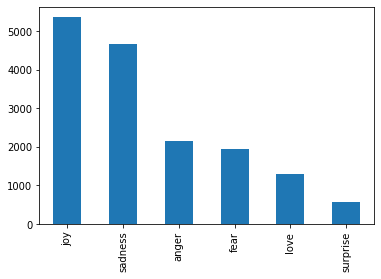

In [ ]:
data = pd.read_csv(train_path, sep=";", header=None, names=['text', 'emotion'],
                               engine="python")
data.emotion.value_counts().plot.bar()

In [ ]:
train.head()

NameError: ignored

In [ ]:
train.count()

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


### Dataset

Here also we will process the examples in the same way we did above. If the label is 'love' we will ask the model to predict the text 'love'

Lets check how t5 encodes the following labels

In [ ]:
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]
for em in emotions:
  print(len(tokenizer.encode(em)))

1
1
1
1
1
1


Here also all the labels are encoded as single ids

In [ ]:
class EmotionDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "emotion"
    self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = target + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'val', 512)
len(dataset)

2000

In [ ]:
data = dataset[42]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

i honestly don't feel discouraged today as i usually do
sadness


### Train

As I said above there's no need to change the model or add task specific head or any other hyperparameters, we'll just change the dataset and that's it!

In [ ]:
!mkdir -p t5_emotion

In [ ]:
args_dict.update({'data_dir': 'emotion_data', 'output_dir': 't5_emotion', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'emotion_data', 'output_dir': 't5_emotion', 'model_name_or_path': 't5-small', 'tokenizer_name_or_path': 't5-small', 'max_seq_length': 512, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 2, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 21}


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [ ]:
def get_dataset(tokenizer, type_path, args):
  return EmotionDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
model = T5FineTuner(args)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /root/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
    

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 60 M  
1   | model.shared                                                          | Embedding                  | 16 M  
2   | model.encoder                                                         | T5Stack                    | 35 M  
3   | model.encoder.block                                                   | ModuleList                 | 18 M  
4   | model.encoder.block.0                                                 | T5Block                    | 3 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 3 M   
6   | model.encoder.block.0.layer.0                                     

INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.2071, device='cuda:0')

INFO:__main__:loss = tensor(0.0781, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0781, device='cuda:0')

INFO:__main__:val_loss = tensor(0.2071, device='cuda:0')



INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.7856, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.1571, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.1658, device='cuda:0')

INFO:__main__:train_loss = tensor(0.1658, device='cuda:0')

INFO:__main__:val_loss = tensor(0.1571, device='cuda:0')



1

### Eval

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

text: i don t feel comfortable playing games with them presenting the bad guy as really a
misunderstood good guy or vice versa

Actual sentiment: joy
predicted sentiment: joy

text: i just say that i am not even feeling embarrassed when i pause and rewind my dvred commercials
if the breaking dawn preview comes on

Actual sentiment: sadness
predicted sentiment: fear

text: i have moments where i just feel so overwhelmed that my eyes well up with tears

Actual sentiment: fear
predicted sentiment: surprise

text: im feeling energetic

Actual sentiment: joy
predicted sentiment: joy

text: i am still feeling a tad strange in those pearly whites

Actual sentiment: surprise
predicted sentiment: surprise

text: i have been learning and re learning the lesson that no matter how i feel about myself or even
how others may feel about me i am treasured by god

Actual sentiment: love
predicted sentiment: joy

text: i was feeling brave i would try to pick up running again

Actual sentiment: joy
predi

#### Test Metrics

In [ ]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for i, out in enumerate(outputs):
  if out not in emotions:
    print(i, 'detected invalid prediction')

In [ ]:
metrics.accuracy_score(targets, outputs)

0.8905

In [ ]:
print(metrics.classification_report(targets, outputs))

              precision    recall  f1-score   support

       anger       0.88      0.85      0.86       275
        fear       0.88      0.87      0.88       224
         joy       0.91      0.92      0.92       695
        love       0.79      0.70      0.74       159
     sadness       0.93      0.94      0.93       581
    surprise       0.68      0.80      0.74        66

    accuracy                           0.89      2000
   macro avg       0.84      0.85      0.85      2000
weighted avg       0.89      0.89      0.89      2000



Now lets plot  the confusion matrix and see for which classes our model is getting confused

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
cm = metrics.confusion_matrix(targets, outputs)

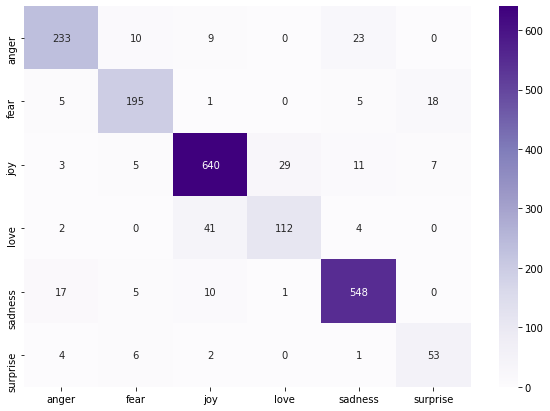

In [ ]:
df_cm = pd.DataFrame(cm, index = ["anger", "fear", "joy", "love", "sadness", "surprise"], columns = ["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Purples', fmt='g')

From the above plot we can see that the most confused classes are 'joy' and 'love' which seems obivous as these two emotions are really close. We can say the same thing 'surprise' and 'anger' as well. So our model is doing pretty well.

## SWAG

Now lets try a more challenging task and see how it performs.

SWAG is a natural language inference and commonsense reasoning task proposed in this [paper](https://arxiv.org/pdf/1808.05326.pdf).

The basic task is that  a model is
given a context **c = (s, n)**: a complete sentence
**s** and a noun phrase **n** that begins a second sentence, as well as a list of possible verb phrase sentence endings **V**. The model must then
select the most appropriate verb phrase **v** in **V**. For example

On stage, a woman takes a seat at the piano. She

a) sits on a bench as her sister plays with the doll.

b) smiles with someone as the music plays.

c) is in the crowd, watching the dancers.

**d) nervously sets her fingers on the keys.**

The correct answer is bolded. Given the above example the model should select **nervously sets her fingers on the keys** as the most appropriate verb phrase

To frame this task in text-2-text setting the example is processed as below.

context: context_text options: 1: option_1 2: option_2 3: option_3 4: option_4

and if the actual label is 1 then the model is asked to predict the text '1'. Here's how the above example will be processed

**Input**

context: On stage, a woman takes a seat at the piano. She  options: 1: sits on a bench as her sister plays with the doll. 2: smiles with someone as the music plays. 3: is in the crowd, watching the dancers. 4: nervously sets her fingers on the keys.

**Target**

4

This is just one possible way to process these examples, there are various other ways we can formulate this problem in text-2-text setting but that's for later.

### Dataset

In [ ]:
import csv
from dataclasses import dataclass

from enum import Enum
from typing import List, Optional
from transformers import PreTrainedTokenizer

In [ ]:
!wget https://raw.githubusercontent.com/rowanz/swagaf/master/data/train.csv
!wget https://raw.githubusercontent.com/rowanz/swagaf/master/data/val.csv

!mkdir swag_data
!mv *.csv swag_data

--2020-05-09 15:06:34--  https://raw.githubusercontent.com/rowanz/swagaf/master/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28243333 (27M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  26.93M  35.9MB/s    in 0.8s    

2020-05-09 15:06:35 (35.9 MB/s) - ‘train.csv’ saved [28243333/28243333]

--2020-05-09 15:06:38--  https://raw.githubusercontent.com/rowanz/swagaf/master/data/val.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7893588 (7.5M) [text/plain]
Saving to: ‘val.csv’

val.cs

In [ ]:
# below code is adapted from https://github.com/huggingface/transformers/blob/master/examples/multiple-choice/utils_multiple_choice.py

@dataclass(frozen=True)
class InputExample:
    """
    A single training/test example for multiple choice
    Args:
        example_id: Unique id for the example.
        question: string. The untokenized text of the second sequence (question).
        contexts: list of str. The untokenized text of the first sequence (context of corresponding question).
        endings: list of str. multiple choice's options. Its length must be equal to contexts' length.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """

    example_id: str
    context: str
    endings: List[str]
    label: Optional[str]

class Split(Enum):
    train = "train"
    dev = "dev"
    test = "test"

class DataProcessor:
    """Base class for data converters for multiple choice data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

class SwagProcessor(DataProcessor):
    """Processor for the SWAG data set."""

    def get_train_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {} train".format(data_dir))
        return self._create_examples(self._read_csv(os.path.join(data_dir, "train.csv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {} dev".format(data_dir))
        return self._create_examples(self._read_csv(os.path.join(data_dir, "val.csv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {} dev".format(data_dir))
        raise ValueError(
            "For swag testing, the input file does not contain a label column. It can not be tested in current code"
            "setting!"
        )
        return self._create_examples(self._read_csv(os.path.join(data_dir, "test.csv")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1", "2", "3"]

    def _read_csv(self, input_file):
        with open(input_file, "r", encoding="utf-8") as f:
            return list(csv.reader(f))

    def _create_examples(self, lines: List[List[str]], type: str):
        """Creates examples for the training and dev sets."""
        if type == "train" and lines[0][-1] != "label":
            raise ValueError("For training, the input file must contain a label column.")

        examples = [
            InputExample(
                example_id=line[2],
                # common beginning of each
                # choice is stored in "sent2".
                context=line[3],
                endings=[line[7], line[8], line[9], line[10]],
                label=line[11],
            )
            for line in lines[1:]  # we skip the line with the column names
        ]

        return examples

In [ ]:
class SwagDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.data_dir = data_dir
    self.type_path = type_path
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self.proc = SwagProcessor()

    self._build()
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def __len__(self):
    return len(self.inputs)
  
  def _build(self):
    if self.type_path == 'train':
      examples = self.proc.get_train_examples(self.data_dir)
    else:
      examples = self.proc.get_dev_examples(self.data_dir)
    
    for example in examples:
      self._create_features(example)
  
  def _create_features(self, example):
    input_ = example.context
    options = ['%s: %s' % (i, option) for i, option in zip('1234', example.endings)]
    options = " ".join(options)
    input_ = "context: %s  options: %s </s>" % (input_, options)
    target = "%s </s>" % str(int(example.label) + 1)

    # tokenize inputs
    tokenized_inputs = self.tokenizer.batch_encode_plus(
        [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
    )
    # tokenize targets
    tokenized_targets = self.tokenizer.batch_encode_plus(
        [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
    )

    self.inputs.append(tokenized_inputs)
    self.targets.append(tokenized_targets)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:filelock:Lock 140245777042344 acquired on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpv2ybakmg


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:filelock:Lock 140245777042344 released on /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f.lock
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f

In [ ]:
dataset = SwagDataset(tokenizer, data_dir='swag_data', type_path='val')
len(dataset)

INFO:__main__:LOOKING AT swag_data dev


20006

In [ ]:
data = dataset[69]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

context: A little girl plays softly the drums holding two sticks while she is singing on a microphone. The, the girl options: 1: take in the greeting and an asian girl followed by two people standing on stage. 2: holds the microphone up and begins to girl dance an entire time. 3: claps the girls hands anxiously. 4: plays more fast the drums.
4


### Train

In [ ]:
!mkdir -p t5_swag

In [ ]:
args_dict.update({'data_dir': 'swag_data', 'output_dir': 't5_swag', 'num_train_epochs': 3})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'swag_data', 'output_dir': 't5_swag', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 3, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [ ]:
def get_dataset(tokenizer, type_path, args):
  return SwagDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
model = T5FineTuner(args)

INFO:filelock:Lock 140242832534944 acquired on /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpwv74k3ig


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json in cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:filelock:Lock 140242832534944 released on /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b.lock
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165

INFO:filelock:Lock 140242971659568 acquired on /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa.lock
INFO:transformers.file_utils:https://cdn.huggingface.co/t5-base-pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp5pcfx_u3


INFO:transformers.file_utils:storing https://cdn.huggingface.co/t5-base-pytorch_model.bin in cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:filelock:Lock 140242971659568 released on /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa.lock
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/t5-base-pytorch_model.bin from cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa


INFO:transformers.modeling_utils:Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                     

INFO:__main__:LOOKING AT swag_data train


INFO:__main__:LOOKING AT swag_data dev


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.3535, device='cuda:0')

INFO:__main__:loss = tensor(0.3080, device='cuda:0')

INFO:__main__:train_loss = tensor(0.3080, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3535, device='cuda:0')



INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.5107, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.3268, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.5484, device='cuda:0')

INFO:__main__:train_loss = tensor(0.5484, device='cuda:0')

INFO:__main__:val_loss = tensor(0.3268, device='cuda:0')

INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1

### Eval

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset =  SwagDataset(tokenizer, data_dir='swag_data', type_path='val')
loader = DataLoader(dataset, batch_size=32, num_workers=4)

INFO:__main__:LOOKING AT swag_data dev


In [ ]:
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

In [ ]:
for i, out in enumerate(outputs):
  if out not in "1234":
    print(i, 'detected invalid prediction')

In [ ]:
metrics.accuracy_score(targets, outputs)

0.7397280815755274

This is great! We have achieved almost 74% accuracy with this simple formulation. This is great becuase with BERT like models to make a prediction on single example the model needs to do 4 forward passes, one for each possible endings and then the logits are concatenated together for all 4 passes and then passed through final softmax layer to produce 4 probabilities. This approach needs only a single pass for one example.